## **Predicción de la vida útil restante (RUL) de motores de turbofán basado en Ciencia de Datos y Aprendizaje Automático (LSTM).**

En este notebook me enfocaré en el desarrollo del modelo de regresión lineal con Redes Neuronales LSTM, el EDA y la importancia del estudio fueron desarrollados en el notebook Predicting Remaining Useful Life (RUL). 

Las redes LSTM (Long Short-Term Memory) son especialmente adecuadas para la predicción de la vida útil restante (RUL) de motores de turbofán debido a su capacidad para modelar dependencias temporales de largo plazo en datos secuenciales, como los registrados por sensores durante el funcionamiento del motor. A diferencia de los modelos tradicionales, las LSTM pueden aprender patrones complejos y dinámicos a lo largo del tiempo, lo que les permite capturar la evolución del estado del motor y anticipar su deterioro de manera más precisa. Esta capacidad de memoria interna y aprendizaje adaptativo convierte a las LSTM en una herramienta poderosa para aplicaciones de mantenimiento predictivo en entornos industriales.

### **DESARROLLO Y PIPELINE.**

#### **Funciones y Librerías.**

In [3]:
%matplotlib inline
#Librerias importadas
import pandas as pd
import numpy as np
import random
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import GroupShuffleSplit

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, TimeDistributed
from keras.layers import Input, Masking, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, InputLayer

def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)  # Para operaciones hash internas
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Fuerza determinismo en operaciones de TF
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # Determinismo en kernels de GPU
    random.seed(seed)              # Semilla para random de Python
    np.random.seed(seed)           # Semilla para NumPy
    tf.random.set_seed(seed)       # Semilla para TensorFlow

    # Configuración para evitar que TF use algoritmos no deterministas en GPU
    tf.config.experimental.enable_op_determinism()


seed = 42
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Parámetros globales
BATCH_SIZE = 32 #64
EPOCHS = 10 #30
LR = 0.001 # OPTIMIZADOR adam 0.001
sequence_length=20

In [4]:
import torch
torch.cuda.is_available()


False

In [5]:
#SEGMENTO DONDE DEFINO FUNCIONES A UTILIZAR

# Esta función evalúa el desempeño de un modelo de regresión
def evaluate(y_true, y_hat, label='test'):
    """
    Evalúa el desempeño de un modelo de regresión utilizando RMSE y R².

    Parámetros:
    y_true -- valores reales de la variable dependiente (array o lista)
    y_hat -- valores predichos por el modelo (array o lista)
    label -- etiqueta opcional para identificar el conjunto evaluado (por defecto: 'test')
    """

    # Calcula el Error Cuadrático Medio (MSE)
    mse = mean_squared_error(y_true, y_hat)
    # Calcula la Raíz del MSE (RMSE), que indica el error promedio en las mismas unidades que la variable dependiente
    rmse = np.sqrt(mse)
    # Calcula el Coeficiente de Determinación (R²), que mide la proporción de varianza explicada por el modelo
    variance = r2_score(y_true, y_hat)

    # Imprime los resultados de evaluación con una etiqueta
    print(f'{label} set RMSE: {rmse:.4f}, R²: {variance:.4f}')

def add_remaining_useful_life(df):
    """
    Añade la columna RUL (Remaining Useful Life) al dataframe C-MAPSS.

    Parámetros:
    df -- DataFrame con datos de los sensores, que debe incluir las columnas 'unit_nr' y 'time_cycles'

    Retorna:
    Un nuevo DataFrame con una columna adicional llamada 'RUL'
    """

    # Paso 1: Calcular el número máximo de ciclos por cada unidad (motor)
    # Esto representa el ciclo en el que la unidad falló (fin de su vida útil)
    max_cycles_per_unit = df.groupby("unit_nr")["time_cycles"].transform('max')

    # Paso 2: Calcular el Remaining Useful Life restando el ciclo actual al máximo ciclo
    df["RUL"] = max_cycles_per_unit - df["time_cycles"]

    # Retornar el DataFrame modificado con la columna RUL añadida
    return df

In [6]:
def plot_rul_comparison(y_true, y_pred, clip_upper=125, buffer=0.05, fixed_limits=True):
    """
    Visualiza comparación entre RUL real y predicho con límites configurables
    
    Parámetros:
        y_true: Valores reales de RUL
        y_pred: Valores predichos de RUL
        clip_upper: Valor máximo para recortar RUL real (300 según tu imagen)
        buffer: Margen porcentual (solo se usa si fixed_limits=False)
        fixed_limits: Si True, usa límites fijos 0-300
    """
    # Convertir y procesar datos
    y_true_f = pd.to_numeric(np.array(y_true).ravel(), errors='coerce').clip(max=clip_upper)
    y_pred_f = np.array(y_pred).ravel().astype(float)
    mask = ~np.isnan(y_true_f)
    y_true_f, y_pred_f = y_true_f[mask], y_pred_f[mask]
    
    # Configurar límites
    if fixed_limits:
        x_min, x_max = -75, 250
        y_min, y_max = -75, 250
    else:
        y_min = min(np.min(y_true_f), np.min(y_pred_f))
        y_max = max(np.max(y_true_f), np.max(y_pred_f))
        range_padding = (y_max - y_min) * buffer
        x_min, x_max = y_min-range_padding, y_max+range_padding
        y_min, y_max = x_min, x_max
    
    # Crear figura
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Scatter plot
    ax.scatter(y_true_f, y_pred_f, alpha=0.7, color='#1f77b4', edgecolor='black', label='Predicciones')
    
    # Línea ideal
    ax.plot([x_min, x_max], [x_min, x_max], 'r--', label='Ideal (y = x)')
    
    # Configurar ejes (usando los límites definidos)
    ax.set(xlabel='RUL Real',
           ylabel='RUL Predicha',
           title='Dispersión: RUL Real vs RUL Predicha',
           xlim=(x_min, x_max),
           ylim=(y_min, y_max))
    
    # Cuadrícula y leyenda
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    
    plt.tight_layout()
    return fig

In [7]:
# 1. Cargar y concatenar datasets
def load_and_concatenate_cmaps():
    datasets = []
    for i in range(1, 5):
        url_train = f'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/train_FD00{i}.txt'
        df = pd.read_csv(url_train, sep=' ', header=None)
        df.dropna(axis=1, inplace=True)
        index_names = ['unit_nr', 'time_cycles']
        setting_names = ['altitude', 'mach', 'temperature']
        sensor_names = ["t2", "t24", "t30", "t50", "p2", "p15", "p30","nf", "nc", "epr", "ps30", "phi", "nrf", "nrc", "bpr", "farb",
            "htbleed", "nf_dmd", "pcnfr_dmd", "w31", "w32"]
        col_names = index_names + setting_names + sensor_names
        df.columns=col_names
        #df['dataset'] = f'FD00{i}'
        #df['fd'] = i
        datasets.append(df)
    return pd.concat(datasets, axis=0, ignore_index=True)

In [8]:
# 1. Cargar todos los conjuntos de prueba y RUL reales
def load_and_concatenate_test_sets():
    dfs_test, dfs_rul = [], []
    for i in range(1, 5):
        url_test = f'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/test_FD00{i}.txt'
        url_rul = f'https://raw.githubusercontent.com/Jordyggg/CMAPPSTURBOFANUSFQML/refs/heads/main/CMaps/RUL_FD00{i}.txt'

        df_test = pd.read_csv(url_test, sep=' ', header=None)
        df_test.dropna(axis=1, inplace=True)
        index_names = ['unit_nr', 'time_cycles']
        setting_names = ['altitude', 'mach', 'temperature']
        sensor_names = ["t2", "t24", "t30", "t50", "p2", "p15", "p30",
            "nf", "nc", "epr", "ps30", "phi", "nrf", "nrc", "bpr", "farb",
            "htbleed", "nf_dmd", "pcnfr_dmd", "w31", "w32"]
        col_names = index_names + setting_names + sensor_names
        df_test.columns=col_names
        df_rul = pd.read_csv(url_rul, header=None)
        df_rul.columns = ['RUL']

        dfs_test.append(df_test)
        dfs_rul.append(df_rul)
    return pd.concat(dfs_test, axis=0, ignore_index=True) , pd.concat(dfs_rul, axis=0, ignore_index=True)

In [9]:
def add_operating_conditions(df, n_clusters=9):
    op_features = df[['altitude', 'mach', 'temperature']]
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['operating_condition_id'] = kmeans.fit_predict(op_features)
    return df

In [10]:
def condition_scaler(df_train, df_test, sensor_names):
    # apply operating condition specific scaling
    scaler = StandardScaler()
    for condition in df_train['operating_condition_id'].unique():
        scaler.fit(df_train.loc[df_train['operating_condition_id']==condition, sensor_names])
        df_train.loc[df_train['operating_condition_id']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['operating_condition_id']==condition, sensor_names])
        df_test.loc[df_test['operating_condition_id']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['operating_condition_id']==condition, sensor_names])
    return df_train, df_test

In [11]:
def add_operating_conditions2(df, alt_col='altitude', mach_col='mach', temp_col='temperature'):
    """
    Añade una columna 'operating_condition_id' al DataFrame en base a las combinaciones únicas
    de altitud, Mach y temperatura (redondeadas para evitar ruido).

    Parámetros:
    - df: DataFrame original con las columnas de altitud, Mach y temperatura.
    - alt_col, mach_col, temp_col: Nombres de las columnas correspondientes.

    Devuelve:
    - El DataFrame original con una nueva columna 'operating_condition_id'.
    - Un DataFrame con las combinaciones únicas de condiciones operativas.
    """
    df_grouped = df.copy()

    # Redondeo para agrupar correctamente condiciones similares
    df_grouped['alt'] = df_grouped[alt_col].round(0)
    df_grouped['Mach'] = df_grouped[mach_col].round(2)
    df_grouped['TRA'] = df_grouped[temp_col].round(1)

    # Crear tupla de condición operativa y asignar códigos únicos
    df_grouped['operating_condition'] = df_grouped[['alt', 'Mach', 'TRA']].apply(tuple, axis=1)
    df_grouped['operating_condition_id'] = df_grouped['operating_condition'].astype('category').cat.codes

    # Asignar la columna al DataFrame original
    df['operating_condition_id'] = df_grouped['operating_condition_id'].astype(int)

    # También retorna las combinaciones únicas y sus conteos por si lo necesitas
    condition_counts = df_grouped.groupby('operating_condition_id').size().reset_index(name='count')
    unique_conditions = df_grouped[['operating_condition_id', 'alt', 'Mach', 'TRA']].drop_duplicates()
    unique_conditions = unique_conditions.merge(condition_counts, on='operating_condition_id')

    return df

In [12]:
# before we start plotting, lets implement the condition specific scaling
def add_operating_condition(df):
    df_op_cond = df.copy()
    
    df_op_cond['altitude'] = df_op_cond['altitude'].round()
    df_op_cond['mach'] = df_op_cond['mach'].round(decimals=2)
    
    # converting settings to string and concatanating makes the operating condition into a categorical variable
    df_op_cond['operating_condition_id'] = df_op_cond['altitude'].astype(str) + '_' + \
                        df_op_cond['mach'].astype(str) + '_' + \
                        df_op_cond['temperature'].astype(str)
    
    return df_op_cond

In [13]:
def scaling_global(df_train, df_test, feature_columns):
    """
    Estandariza características globalmente (sin considerar condiciones operativas), 
    guardando los parámetros de escalamiento
    
    Args:
        df_train (pd.DataFrame): DataFrame de entrenamiento
        df_test (pd.DataFrame): DataFrame de prueba
        feature_columns (list): Lista de columnas a escalar
        
    Returns:
        tuple: (df_train_scaled, df_test_scaled, scaler) 
               donde scaler es el escalador ajustado
    """
    # Crear copias para no modificar los DataFrames originales
    train_scaled = df_train.copy()
    test_scaled = df_test.copy()
    
    # Crear y ajustar scaler con todos los datos de entrenamiento
    scaler = StandardScaler()
    scaler.fit(df_train[feature_columns])
    
    # Transformar datos de entrenamiento y prueba
    train_scaled[feature_columns] = scaler.transform(df_train[feature_columns])
    test_scaled[feature_columns] = scaler.transform(df_test[feature_columns])
    
    return train_scaled, test_scaled

In [14]:
def scaling_by_condition(df_train, df_test, feature_columns, condition_column='operating_condition_id'):
    """
    Estandariza características por condición operativa, guardando los parámetros de escalamiento
    
    Args:
        df_train (pd.DataFrame): DataFrame de entrenamiento
        df_test (pd.DataFrame): DataFrame de prueba
        feature_columns (list): Lista de columnas a escalar
        condition_column (str): Columna que define las condiciones operativas
        
    Returns:
        tuple: (df_train_scaled, df_test_scaled, scalers_dict) 
               donde scalers_dict contiene los escaladores por condición
    """
    scalers_dict = {}
    
    # Crear copias para no modificar los DataFrames originales
    train_scaled = df_train.copy()
    test_scaled = df_test.copy()
    
    for condition in df_train[condition_column].unique():
        # Crear y ajustar scaler solo con datos de entrenamiento
        scaler = StandardScaler()
        scaler.fit(df_train.loc[df_train[condition_column]==condition, feature_columns])
        
        # Guardar scaler para uso futuro
        scalers_dict[condition] = scaler
        
        # Transformar datos de entrenamiento y prueba
        train_scaled.loc[df_train[condition_column]==condition, feature_columns] = scaler.transform(
            df_train.loc[df_train[condition_column]==condition, feature_columns])
        
        # Solo transformar datos de prueba si la condición existe en test
        if condition in df_test[condition_column].unique():
            test_scaled.loc[df_test[condition_column]==condition, feature_columns] = scaler.transform(
                df_test.loc[df_test[condition_column]==condition, feature_columns])
    
    return train_scaled, test_scaled

In [15]:
def fix_unit_nr_continuity(df, unit_col='unit_nr'):
    """
    Corrige la continuidad de la columna de unidades 'unit_nr' en un DataFrame concatenado
    donde los unit_nr se reinician después de cada dataset.

    Parámetros:
    - df: DataFrame de entrada.
    - unit_col: nombre de la columna que contiene el identificador de unidades (por defecto 'unit_nr').

    Retorna:
    - DataFrame con una nueva columna 'unit_nr_fixed' que tiene la secuencia continua corregida.
    """
    # Detectar los puntos donde unit_nr se reinicia
    unit_changes = df[unit_col].diff() < 0

    # Crear un grupo incremental donde haya cambios
    group = unit_changes.cumsum()

    # Corregir unit_nr sumando un offset basado en el número de resets detectados
    df['unit_nr_fixed'] = df[unit_col] + (group * df[unit_col].max())

    # Mapear a una secuencia ordenada 1, 2, 3, 4, ...
    unit_mapping = {old: new for new, old in enumerate(df['unit_nr_fixed'].unique(), start=1)}
    df['unit_nr_fixed'] = df['unit_nr_fixed'].map(unit_mapping)
    df = df.drop(columns=['unit_nr']).rename(columns={'unit_nr_fixed': 'unit_nr'})

    return df



In [16]:
def plot_sensor_distribution(df_scaled, sensor_name, bins=30, figsize=(10, 5), title='Original'):
    """
    Visualiza la distribución global de un sensor escalado
    """
    plt.figure(figsize=figsize)
    
    # Histograma + KDE
    sns.histplot(df_scaled[sensor_name], bins=bins, kde=True)

    
    plt.title(f'Distribución de {sensor_name} {title}')
    plt.xlabel('Valor Escalado')
    plt.ylabel('Frecuencia')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [17]:
# plot predictions
def plot_rul_predictions(y_true, y_pred, title):
    """
    Visualiza las predicciones de RUL en modo scatter o serie temporal.
    
    Parámetros:
    - y_true: array-like o pd.Series. Valores reales de RUL.
    - y_pred: array-like. Predicciones del modelo.
    """
    sns.set(style="whitegrid")
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

  
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='RUL Real', marker='o', color='#1f77b4')
    plt.plot(y_pred, label='RUL Predicha', marker='x', linestyle='--', color='#ff7f0e')
    plt.xlabel('Motor', fontsize=12)
    plt.ylabel('Remaining Useful Life', fontsize=12)
    plt.title('Serie Temporal de Predicción de RUL-'+title, fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
        # Leyenda fuera del gráfico
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.tight_layout()
    plt.show()

#### **Carga de Datos.**

- Se concatenan los datos.
- Se indexan los unit motores.

In [18]:
df_train = load_and_concatenate_cmaps()
df_test, y_true = load_and_concatenate_test_sets()
df_train = fix_unit_nr_continuity(df_train, unit_col='unit_nr')
df_test = fix_unit_nr_continuity(df_test, unit_col='unit_nr')

#### **Preprocesamiento.**

- Se calcula la rul.
- Todos los sensores tipo float.
- Añadimos el operation ID.
- Se adapta la variable objetivo (CLIP RUL).
- Se agrupa el set de prueba por motor.

In [19]:
index_names = ['unit_nr', 'time_cycles']
setting_names = ['altitude', 'mach', 'temperature']
sensor_cols = ["t2", "t24", "t30", "t50", "p2", "p15", "p30","nf", 
               "nc", "epr", "ps30", "phi", "nrf", "nrc", "bpr", "farb",
                "htbleed", "nf_dmd", "pcnfr_dmd", "w31", "w32"]

In [20]:
# Añadimos la variable objetivo
df_train = add_remaining_useful_life(df_train)

In [21]:
df_train[['htbleed', 'nf_dmd']] = df_train[['htbleed', 'nf_dmd']].astype(float)
df_test[['htbleed', 'nf_dmd']] = df_test[['htbleed', 'nf_dmd']].astype(float)

In [22]:
# Definimos set de entrenamiento y prueba
X_train = df_train[setting_names + sensor_cols].copy()
y_train = df_train['RUL'].copy()
y_train_clipped = y_train.clip(upper=125) # usamos la clip rul

X_test = df_test.drop('time_cycles', axis=1).groupby('unit_nr').last().copy() # obtenemos la ultima fila

##### **Método para Featuring Selección.**
Una combinación entre correlaciones Pearson, Spearman y Mutual Information entre sensores y la RUL. La idea es confirmar que con más características del dataset el modelo mejora, lo que lo haré  en la optimización de hiperparámetros, asi que repetimos el análisis hecho en el EDA de seleccion de características.

In [23]:
def compute_sensor_rul_relationship(df, sensor_cols, rul_col='RUL'):
    """
    Calcula correlaciones Pearson, Spearman y Mutual Information entre sensores y la RUL.
    
    Parámetros:
        df (DataFrame): Dataset completo que incluye sensores y RUL.
        sensor_cols (list): Lista de columnas de sensores.
        rul_col (str): Nombre de la columna RUL (default 'RUL').
    
    Retorna:
        DataFrame ordenado por Mutual Information descendente.
    """
    # Pearson
    pearson_corr = df[sensor_cols + [rul_col]].corr(method='pearson')[rul_col].drop(rul_col)
    
    # Spearman
    spearman_corr = df[sensor_cols + [rul_col]].corr(method='spearman')[rul_col].drop(rul_col)
    
    # Mutual Information
    X = df[sensor_cols]
    y = df[rul_col]
    mi = mutual_info_regression(X, y, random_state=42)
    mi_series = pd.Series(mi, index=sensor_cols)
    
    # Consolidar resultados
    result = pd.DataFrame({
        'Pearson_corr': pearson_corr,
        'Spearman_corr': spearman_corr,
        'Mutual_Information': mi_series
    })
    
    return result.sort_values(by='Mutual_Information', ascending=False)

In [24]:
low_corr_sensors= compute_sensor_rul_relationship(df_train.copy(), sensor_cols)
low_corr_sensors

,Pearson_corr,Spearman_corr,Mutual_Information
ps30,-0.044859,-0.194314,0.478652
t50,-0.032047,-0.187177,0.427666
nf,0.009345,-0.130911,0.353592
bpr,-0.028528,-0.106282,0.331587
phi,0.009980,0.053165,0.304348
p30,0.010196,0.053817,0.285012
t24,0.004582,-0.141042,0.282331
htbleed,-0.020581,-0.158619,0.270897
nrf,0.005335,-0.408596,0.245739
t30,-0.020455,-0.155608,0.244488


#### **Modelo Base.**

Implemento un modelo base como punto de partida, es una regresión lineal más la CLIP RUL.

In [25]:
#Modelo base  
lm = LinearRegression()
lm.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_true.clip(upper=125), y_hat_test)

train set RMSE: 21.9457, R²: 0.7168
test set RMSE: 23.0526, R²: 0.7000


#### **Condiciones de Operación.**

Añadimos el ID de condiciones de operación y escalamos por modos de operación. 

In [26]:
# Añade la condición de operación y se escala por condición.
X_train_condition = add_operating_condition(df_train)
X_test_condition = add_operating_condition(X_test)

Antes que nada, podemos observar la diferencia del escalado por modo de operación y el global, pues obtenemos una mejor distribución en los datos, ayuda al modelo a interpretar mejor los datos.  

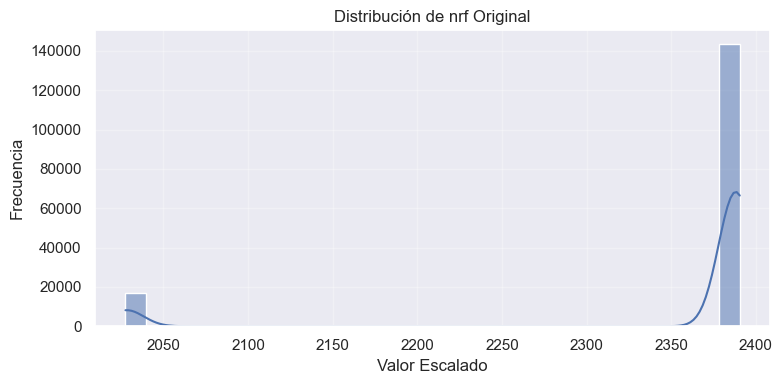

In [27]:
plot_sensor_distribution(X_train_condition,'nrf', bins=30, figsize=(8, 4), title='Original' )

In [28]:
X_train_condition_scaled, X_test_condition_scaled = scaling_by_condition(X_train_condition, X_test_condition, sensor_cols)

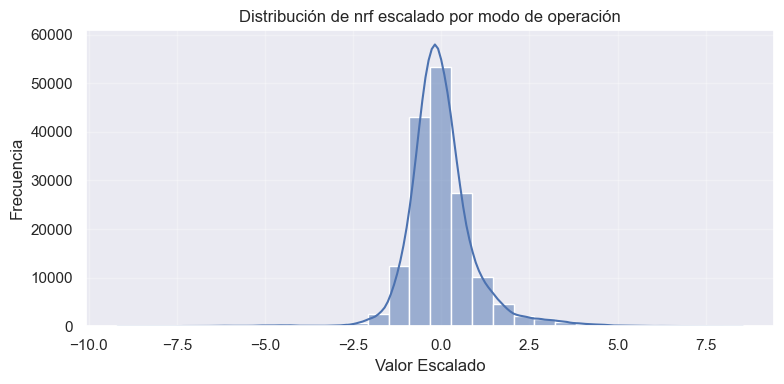

In [29]:
plot_sensor_distribution(X_train_condition_scaled,'nrf', bins=30, figsize=(8, 4), title='escalado por modo de operación')

In [30]:
X_train_condition_scaled2, X_test_condition_scaled2 = scaling_global(X_train_condition, X_test_condition, sensor_cols)

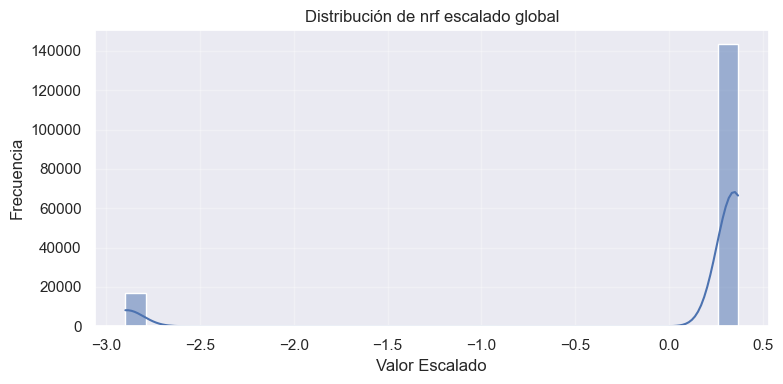

In [31]:
plot_sensor_distribution(X_train_condition_scaled2,'nrf', bins=30, figsize=(8, 4), title='escalado global')

operating_condition_id
42.0_0.84_100.0    28853
0.0_0.0_100.0      28594
10.0_0.25_100.0    17320
20.0_0.7_100.0     17213
35.0_0.84_100.0    17199
25.0_0.62_60.0     17141
-0.0_0.0_100.0     11454
0.0_-0.0_100.0     11320
-0.0_-0.0_100.0    11265
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribución de condiciones operativas en el conjunto de entrenamiento')

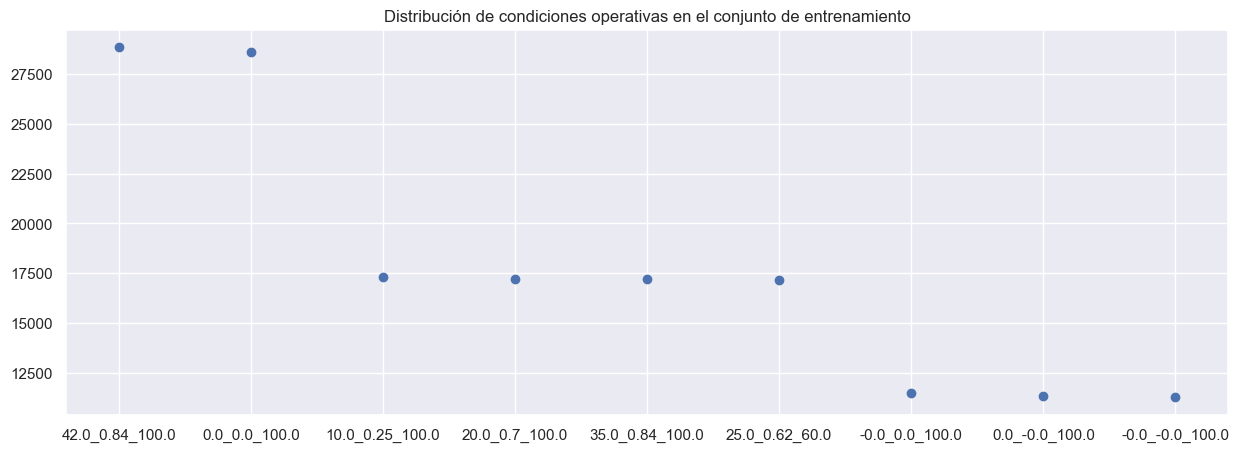

In [32]:
print(X_train_condition['operating_condition_id'].value_counts())

plt.figure(figsize=(15,5))
plt.plot(X_train_condition['operating_condition_id'].value_counts(), 'o')
plt.title('Distribución de condiciones operativas en el conjunto de entrenamiento')

operating_condition_id
42.0_0.84_100.0    133
0.0_0.0_100.0      130
25.0_0.62_60.0      85
35.0_0.84_100.0     75
10.0_0.25_100.0     72
20.0_0.7_100.0      71
-0.0_0.0_100.0      52
-0.0_-0.0_100.0     50
0.0_-0.0_100.0      39
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribución de condiciones operativas en el conjunto de Prueba')

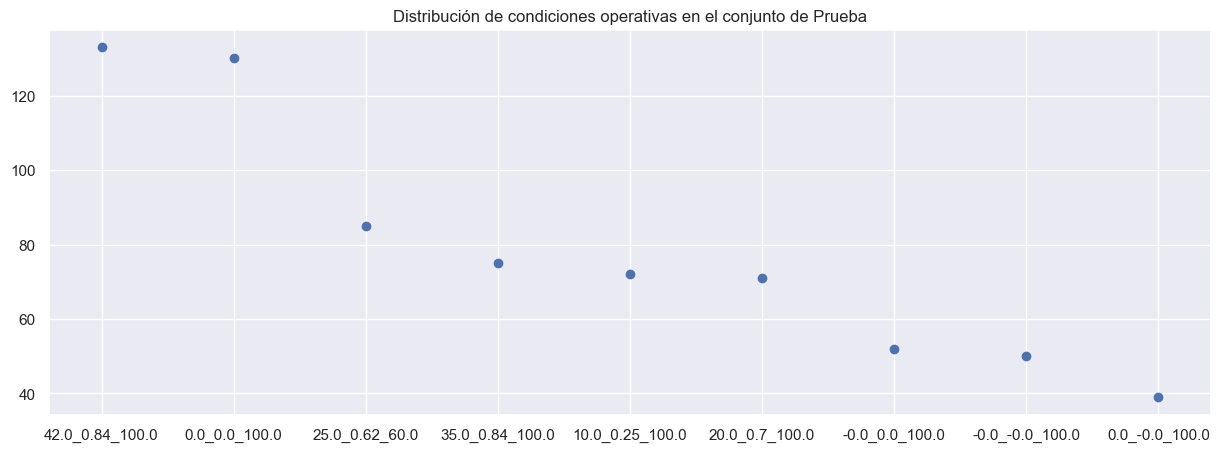

In [33]:
print(X_test_condition['operating_condition_id'].value_counts())

plt.figure(figsize=(15,5))
plt.plot(X_test_condition['operating_condition_id'].value_counts(), 'o')
plt.title('Distribución de condiciones operativas en el conjunto de Prueba')

Estas condiciones operativas tanto en el conjunto de entrenamiento y prueba, corresponden a combinaciones específicas de los tres parámetros operativos del C-MAPSS (generalmente: altitude, Mach, TRA), y reflejan una agrupación más fina que las 6 condiciones usuales codificadas artificialmente (como 1 a 6). 

Obtenida de lo desarrollado en **[1]**, el autor menciona que, estas combinaciones capturan la verdadera variabilidad del entorno operativo, no se pierde información al agrupar artificialmente en 6 clases arbitrarias. Cada combinación representa una configuración específica del motor, lo que puede influir directamente en la degradación.

Adicional van en alineación con el enfoque original del dataset, en el paper original del C-MAPSS y trabajos como los de Saxena et al.**[2]**, se da importancia a la influencia de las condiciones reales sobre el desgaste del motor.

#### **One HOT Encoding.**

Cuando escalas por condición de operación y observas que los sensores estan operando en al menos 6 distintas condiciones de operación inmediatemente piensas en una característica categórica y el uso de OHE, como ya hemos probado en los modelos base, el resultado de los modelos mejoraba ligeramente, sin embargo decido no usar las dummies porque: 1. Por experimentación cuando ajuste los hyperparámetros al parecer los modelos empezaban a sobreajustar porque en n interacciones nunca encontre un mejor modelo que el que ya entrene quitando esto encontre un modelo con un mse de 163 y 2. creo en algo similar a [3] al normalizar los datos de sensores dentro de cada condición operacional, se mantiene la coherencia y agregar las dummies pues tiende a ser redundante y es más fácil agregar otras features (como estadísticas móviles) sin preocuparse por columnas one-hot adicionales.

#### **Smoothing.**

In [34]:
def time_series_smoothing(
    df: pd.DataFrame,
    group_columns: list = ["unit_nr"],
    feature_columns: list = None,
    alpha: float = 0.4
) -> pd.DataFrame:
    """
    Aplica suavizado exponencial a series temporales agrupadas y elimina muestras iniciales.

    Parámetros:
        df: DataFrame de entrada.
        group_columns: Columnas para agrupar (ej: ["unit_nr", "flight_id"]).
        feature_columns: Columnas a suavizar.
        alpha: Factor de suavizado (0(más estricto) < alpha <= 1(más suave)) .
        n_samples: Muestras iniciales a eliminar por grupo.

    Retorna:
        DataFrame procesado.
    """
    df = df.copy()
    
    # 1. Suavizado Exponencial
    smoothed = (
        df.groupby(group_columns, sort=False)[feature_columns]
        .apply(lambda x: x.ewm(alpha=alpha).mean())
        .reset_index(level=0, drop=True)  # Alinear índices
    )
    
    df[feature_columns] = smoothed
    
    return df

In [35]:
X_train_condition_scaled_smoothed = time_series_smoothing(df=X_train_condition_scaled,
    group_columns=["unit_nr"],
    feature_columns=sensor_cols,
    alpha=0.4)   
X_test_condition_scaled_smoothed = time_series_smoothing(df=X_train_condition_scaled,
    group_columns=["unit_nr"],
    feature_columns=sensor_cols,
    alpha=0.4)

####  **Secuencias.**

Idealmente, usas algo como TimeseriesGenerator de tensorflow para crear secuencias, pero hay algunas razones por las que opto por usar código personalizado.

Primero, tenemos que dar cuenta de la unidad. Las secuencias sólo deben tener datos de una sola unidad para evitar la mezcla de registros donde el fallo es inminente con los registros del siguiente motor en el conjunto de trenes que todavía está funcionando bien.

En segundo lugar, la mayoria de series de tiempo suelen utilizar X instancias para predecir Yt-1, mientras que quiero predecir Yt, la última etiqueta perteneciente a la última instancia.

##### Secuencias para el train.

Ejemplo de como las secuencias se generan.

In [36]:
def create_sequences(dataframe, window_size, feature_list, selected_units=None):
    """
    Crea un array de secuencias de longitud fija a partir de un dataframe.
    
    Parámetros:
    ----------
    dataframe : pd.DataFrame
        El DataFrame que contiene los datos originales.
    window_size : int
        Longitud de la ventana o secuencia deseada.
    feature_list : list
        Lista de nombres de columnas que se usarán como características.
    selected_units : np.ndarray o None
        IDs de unidades/motores a procesar. Si es None, procesa todas las unidades únicas.

    Retorna:
    -------
    np.ndarray
        Un array de secuencias de forma (número_de_secuencias, window_size, número_de_características).
    """

    # Si no se especifican unidades, usar todas
    if selected_units is None or selected_units.size == 0:
        selected_units = dataframe['unit_nr'].unique()

    all_sequences = []  # Lista para guardar todas las secuencias generadas

    # Iterar sobre cada unidad/motor individualmente
    for unit_id in selected_units:
        unit_data = dataframe[dataframe['unit_nr'] == unit_id][feature_list].values  # Seleccionar solo las columnas deseadas
        total_records = unit_data.shape[0]

        # Crear ventanas deslizantes (secuencias) para esta unidad
        for start_idx in range(0, total_records - (window_size - 1)):
            end_idx = start_idx + window_size
            sequence = unit_data[start_idx:end_idx, :]  # Extraer ventana
            all_sequences.append(sequence)  # Agregar a la lista general

    # Combinar todas las secuencias en un único array
    sequences_array = np.array(all_sequences, dtype=np.float32)

    return sequences_array


In [37]:
def create_sequences2(df, window_size, feature_cols, target_col):
    sequences = []
    targets = []
    for unit in df['unit_nr'].unique():
        unit_df = df[df['unit_nr'] == unit]
        for i in range(len(unit_df) - window_size):
            seq = unit_df.iloc[i:i+window_size][feature_cols].values
            label = unit_df.iloc[i+window_size][target_col]
            sequences.append(seq)
            targets.append(label)
    return np.array(sequences), np.array(targets)

In [38]:
d = {'unit_nr': [1]*5 + [2]*5,
     'X': [10., 10.2, 10.4, 10.6, 10.8, 20., 20.2, 20.4, 20.6, 20.8],
     'y': [1.4, 1.4, 1.3, 1.2, 1.1, 2.4, 2.4, 2.3, 2.2, 2.1]}
example_df = pd.DataFrame(data=d)
example_df

,unit_nr,X,y
0,1,10.0,1.4
1,1,10.2,1.4
2,1,10.4,1.3
3,1,10.6,1.2
4,1,10.8,1.1
5,2,20.0,2.4
6,2,20.2,2.4
7,2,20.4,2.3
8,2,20.6,2.2
9,2,20.8,2.1


In [39]:
data_array = create_sequences(example_df, 4, ['X']) # por cada Xt tengo Yt
data_array

array([[[10. ],
        [10.2],
        [10.4],
        [10.6]],

       [[10.2],
        [10.4],
        [10.6],
        [10.8]],

       [[20. ],
        [20.2],
        [20.4],
        [20.6]],

       [[20.2],
        [20.4],
        [20.6],
        [20.8]]], dtype=float32)

In [40]:
data, y_g = create_sequences2(example_df, 4, ['X'],['y']) # por cada Xt tengo Yt-1 lo que omumente se usa en ventanas deslizantes fijas


In [41]:
data

array([[[10. ],
        [10.2],
        [10.4],
        [10.6]],

       [[20. ],
        [20.2],
        [20.4],
        [20.6]]])

In [42]:
y_g ## labels del metodo 2

array([[1.1],
       [2.1]])

##### Secuencias para las etiquetas.

In [43]:
def create_labels(dataframe, window_size, target_column, selected_units=None):
    """
    Crea un array de etiquetas (targets) para cada secuencia generada.

    Parámetros:
    ----------
    dataframe : pd.DataFrame
        El DataFrame que contiene los datos originales.
    window_size : int
        Longitud de las secuencias usadas para las entradas.
    target_column : list
        Lista que contiene el nombre de la columna objetivo (por ejemplo ['RUL']).
    selected_units : np.ndarray o None
        IDs de unidades/motores a procesar. Si es None, se procesan todas las unidades únicas.

    Retorna:
    -------
    np.ndarray
        Un array de etiquetas correspondientes a cada secuencia generada.
    """

    # Si no se especifican unidades, usar todas
    if selected_units is None or selected_units.size == 0:
        selected_units = dataframe['unit_nr'].unique()

    all_labels = []  # Lista para almacenar todas las etiquetas

    # Iterar sobre cada unidad/motor individualmente
    for unit_id in selected_units:
        unit_target_values = dataframe[dataframe['unit_nr'] == unit_id][target_column].values  # Extraer la columna objetivo
        total_cycles = unit_target_values.shape[0]

        # Extraer las etiquetas correspondientes al final de cada ventana
        labels_for_unit = unit_target_values[window_size - 1 : total_cycles, :]  # Desde el índice (window_size-1) hasta el final

        # Agregar al conjunto general de etiquetas
        all_labels.append(labels_for_unit)

    # Combinar todas las etiquetas en un único array
    labels_array = np.concatenate(all_labels).astype(np.float32)

    return labels_array

In [44]:
label_array = create_labels(example_df, 4, ['y'])# obtengo Yt del metodo 1
label_array

array([[1.2],
       [1.1],
       [2.2],
       [2.1]], dtype=float32)

##### Secuencias para la prueba.

In [45]:
def create_test_sequences(dataframe, window_size, feature_columns, padding_value):
    """
    Genera secuencias del conjunto de prueba, realizando padding si es necesario (que es padding 
    si el tamaño de la ventana supera a los datos disponibles se rellena con un valor).

    Parámetros:
    ----------
    dataframe : pd.DataFrame
        El DataFrame de prueba que contiene los datos por unidad.
    window_size : int
        Número de pasos de tiempo en cada secuencia.
    feature_columns : list
        Lista de nombres de columnas de características a utilizar.
    padding_value : float
        Valor que se usará para hacer padding si los datos son más cortos que la ventana.

    Retorna:
    -------
    np.ndarray
        Un array de secuencias para cada unidad del conjunto de prueba.
    """

    unit_ids = dataframe['unit_nr'].unique()  # Obtener IDs de las unidades
    all_sequences = []  # Lista para guardar todas las secuencias generadas

    for unit in unit_ids:
        unit_data = dataframe[dataframe['unit_nr'] == unit][feature_columns].values  # Extraer datos de esa unidad

        if unit_data.shape[0] < window_size:
            # Si no hay suficientes datos, crear un array lleno de padding_value
            padded_sequence = np.full((window_size, len(feature_columns)), padding_value, dtype=np.float32)

            # Insertar los datos reales al final del padding
            start_idx = window_size - unit_data.shape[0]
            padded_sequence[start_idx:, :] = unit_data

            final_sequence = padded_sequence
        else:
            # Si hay suficientes datos, simplemente tomar los últimos 'window_size' registros
            final_sequence = unit_data[-window_size:, :]

        # Añadir la secuencia final a la lista
        all_sequences.append(final_sequence)

    # Combinar todas las secuencias en un solo array
    sequences_array = np.stack(all_sequences)

    return sequences_array


In [46]:
#  las secuencia del conjuto de prueba deben tener padding para cubrir el tamaño de la ventana deslizante
create_test_sequences(example_df[example_df['unit_nr']==2], window_size=6, feature_columns=['X'], padding_value=-99.)

array([[[-99. ],
        [ 20. ],
        [ 20.2],
        [ 20.4],
        [ 20.6],
        [ 20.8]]], dtype=float32)

In [48]:
# Metodo 2 para las secuencias en el test
X_test_list = []
feature_cols=['X']
# Para cada unidad, extraemos la última secuencia completa de tamaño WINDOW_SIZE
for unit in example_df['unit_nr'].unique():
    unit_df = example_df[example_df['unit_nr']== unit]
    if len(unit_df) >= sequence_length:
        seq = unit_df.iloc[-sequence_length:][feature_cols].values
    else:
        # Padding si hay menos de WINDOW_SIZE ciclos
        pad = np.zeros((sequence_length - len(unit_df), len(feature_cols)))
        seq = np.vstack((pad, unit_df[feature_cols].values))
    X_test_list.append(seq)

X_test = np.array(X_test_list)

In [ ]:
X_test

array([[[ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [10. ],
        [10.2],
        [10.4],
        [10.6],
        [10.8]],

       [[ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [ 0. ],
        [20. ],
        [20.2],
        [20.4],
        [20.6],
        [20.8]]])

##### **En resumen.** #####

| *   | unit_nr | X    | y    | *   | unit_nr | X    | y    |
|-----|---------|------|------|-----|---------|------|------|
| 0   | 1       | **10.0** | 1.4  | 0   | 1       | **10.0** | 1.4  |
| 1   | 1       | **10.2** | 1.4  | 1   | 1       | **10.2** | 1.4  |
| 2   | 1       | **10.4** | 1.3  | 2   | 1       | **10.4** | 1.3  |
| 3   | 1       | **10.6** | 1.2  | 3   | 1       | **10.6** | **1.2**  |
| 4   | 1       | 10.8 | **1.1**  | 4   | 1       | **10.8** | **1.1**  |
| 5   | 2       | **20.0** | 2.4  | 5   | 2       | **20.0** | 2.4  |
| 6   | 2       | **20.2** | 2.4  | 6   | 2       | **20.2** | 2.4  |
| 7   | 2       | **20.4** | 2.3  | 7   | 2       | **20.4** | 2.3  |
| 8   | 2       | **20.6** | 2.2  | 8   | 2       | **20.6** | **2.2**  |
| 9   | 2       | 20.8 | **2.1**  | 9   | 2       | **20.8** | **2.1**  |

**Figura 1**: resaltado en negrita, A la izquierda, el problema tradicional de la serie temporal enmarcando donde \( X \) se utilizan los cronómetros para predecir \( $Y_{t-1}$ \). A la derecha, el encuadre de problema para predecir \( $Y_{t}$ \) fuente **[4]**.

### **LSTM.**

#### **Procesamiento LSTM.**

In [49]:
df_train = add_remaining_useful_life(df_train)
df_train = fix_unit_nr_continuity(df_train, unit_col='unit_nr')

In [50]:
df_train

,time_cycles,altitude,mach,temperature,t2,t24,t30,t50,p2,p15,...,nrc,bpr,farb,htbleed,nf_dmd,pcnfr_dmd,w31,w32,RUL,unit_nr
0,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,...,8138.62,8.4195,0.03,392.0,2388.0,100.0,39.06,23.4190,191,1
1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,...,8131.49,8.4318,0.03,392.0,2388.0,100.0,39.00,23.4236,190,1
2,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,...,8133.23,8.4178,0.03,390.0,2388.0,100.0,38.95,23.3442,189,1
3,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,...,8133.83,8.3682,0.03,392.0,2388.0,100.0,38.88,23.3739,188,1
4,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,...,8133.80,8.4294,0.03,393.0,2388.0,100.0,38.90,23.4044,187,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160354,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,15.46,...,8185.69,8.4541,0.03,372.0,2319.0,100.0,29.11,17.5234,4,709
160355,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,21.57,...,8185.47,8.2221,0.03,396.0,2388.0,100.0,39.38,23.7151,3,709
160356,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,21.57,...,8193.94,8.2525,0.03,395.0,2388.0,100.0,39.78,23.8270,2,709
160357,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,7.96,...,8125.64,9.0515,0.02,337.0,2223.0,100.0,15.26,9.0774,1,709


In [51]:
X_train_interim = add_operating_condition(df_train)
X_test_interim = add_operating_condition(df_test)

In [52]:
X_train_interim, X_test_interim = scaling_by_condition(X_train_interim, X_test_interim, sensor_cols)

In [53]:
X_train_interim = time_series_smoothing(X_train_interim,['unit_nr'], sensor_cols, 0.1)
X_test_interim = time_series_smoothing(X_test_interim, ['unit_nr'], sensor_cols, 0.1)

In [54]:
X_train_interim['RUL'] = df_train['RUL'].clip(upper=125)
X_train_interim

,time_cycles,altitude,mach,temperature,t2,t24,t30,t50,p2,p15,...,bpr,farb,htbleed,nf_dmd,pcnfr_dmd,w31,w32,RUL,unit_nr,operating_condition_id
0,1,-0.0,-0.00,100.0,0.000000e+00,-1.407703,0.072535,-0.604786,-5.329071e-15,0.514204,...,0.047732,-1.387779e-17,-0.505026,0.0,0.000000e+00,0.639031,0.513135,125,1,-0.0_-0.0_100.0
1,2,0.0,-0.00,100.0,-5.983518e-14,-1.076993,0.252869,-0.463493,-4.394146e-15,0.518916,...,0.158631,-1.387779e-17,-0.501470,0.0,0.000000e+00,0.504432,0.533544,125,1,0.0_-0.0_100.0
2,3,-0.0,0.00,100.0,-3.775578e-14,-0.828407,0.094146,-0.378552,-4.083654e-15,0.518387,...,0.106348,-1.259755e-17,-0.941290,0.0,0.000000e+00,0.375548,0.328374,125,1,-0.0_0.0_100.0
3,4,0.0,0.00,100.0,-2.677707e-14,-0.712845,-0.225361,-0.418478,-3.929266e-15,0.510105,...,-0.188003,-1.296982e-17,-0.824187,0.0,0.000000e+00,0.235869,0.294533,125,1,0.0_0.0_100.0
4,5,-0.0,-0.00,100.0,-2.023826e-14,-0.625065,-0.403333,-0.322744,-4.271090e-15,0.511106,...,-0.087549,-1.319154e-17,-0.602984,0.0,0.000000e+00,0.168796,0.322929,125,1,-0.0_-0.0_100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160354,251,10.0,0.25,100.0,1.752884e-14,0.290259,1.188805,1.087676,8.345452e-16,-2.325610,...,-3.154666,2.108261e-01,1.287365,0.0,-3.352286e-15,1.661430,1.718206,4,709,10.0_0.25_100.0
160355,252,0.0,0.00,100.0,1.577596e-14,0.423612,1.216406,1.185695,3.958194e-16,-2.340766,...,-3.191070,1.897435e-01,1.343040,0.0,-3.017057e-15,1.695882,1.807867,3,709,0.0_0.0_100.0
160356,253,0.0,0.00,100.0,1.419836e-14,0.593559,1.375972,1.313239,9.660517e-19,-2.354406,...,-3.169468,1.707691e-01,1.333580,0.0,-2.715351e-15,1.895749,1.967365,2,709,0.0_0.0_100.0
160357,254,35.0,0.84,100.0,2.983155e-14,0.554208,1.492589,1.404816,-1.767662e-16,-2.443871,...,-3.273839,1.536922e-01,1.396457,0.0,-2.443816e-15,2.020741,1.983764,1,709,35.0_0.84_100.0


In [55]:
def prepare_sequential_data(df_entreno, df_prueba, secuencia, columnas_sensor, nombre_etiqueta, valor_relleno,
                                 fn_secuencia, fn_etiqueta, fn_test, n_slpits):
    """
    Genera conjuntos de entrenamiento, validación y prueba a partir de datos con estructura secuencial.
    
    Parámetros:
    - df_entreno: DataFrame con los datos de entrenamiento
    - df_prueba: DataFrame con los datos de prueba
    - secuencia: longitud de las VENTANAS (int)
    - columnas_sensor: lista con nombres de columnas de entrada
    - nombre_etiqueta: lista con la columna de la etiqueta (ej. ['RUL'])
    - valor_relleno: valor a usar en padding del test
    - fn_secuencia: función para generar las secuencias
    - fn_etiqueta: función para generar las etiquetas
    - fn_test: función para generar secuencias de prueba (una por unidad)

    Retorna:
    - X_entreno, y_entreno, X_valida, y_valida, X_total, y_total, X_prueba
    """

    # División por unidades únicas usando GroupShuffleSplit
    divisor = GroupShuffleSplit(n_splits=n_slpits, train_size=0.80, random_state=42)
    unidades = df_entreno['unit_nr'].unique()

    idx_entreno, idx_valida = next(divisor.split(unidades, groups=unidades))
    unidades_entreno = unidades[idx_entreno]
    unidades_valida = unidades[idx_valida]

    # Secuencias y etiquetas para entrenamiento y validación
    X_entreno = fn_secuencia(df_entreno, secuencia, columnas_sensor, unidades_entreno)
    y_entreno = fn_etiqueta(df_entreno, secuencia, nombre_etiqueta, unidades_entreno)

    X_valida = fn_secuencia(df_entreno, secuencia, columnas_sensor, unidades_valida)
    y_valida = fn_etiqueta(df_entreno, secuencia, nombre_etiqueta, unidades_valida)

    # Secuencias y etiquetas completas del conjunto de entrenamiento (sin dividir)
    X_total = fn_secuencia(df_entreno, secuencia, columnas_sensor)
    y_total = fn_etiqueta(df_entreno, secuencia, nombre_etiqueta)

    # Preparación del conjunto de prueba: última secuencia por unidad con padding si es necesario
    generador_prueba = (
        list(fn_test(df_prueba[df_prueba['unit_nr'] == u], secuencia, columnas_sensor, valor_relleno))
        for u in df_prueba['unit_nr'].unique()
    )
    X_prueba = np.concatenate(list(generador_prueba)).astype(np.float32)
    #test_array= create_test_sequences(X_test_interim, sequence_length, remaining_sensors, -99.)

    return X_entreno, y_entreno, X_valida, y_valida, X_total, y_total, X_prueba


In [56]:
drp_sensors=['p15', 'epr', 'p2', 't2', 'farb', 'nf_dmd', 'pcnfr_dmd']
remaing_sensors= [s for s in sensor_cols if s not in drp_sensors]
remaing_sensors

['t24',
 't30',
 't50',
 'p30',
 'nf',
 'nc',
 'ps30',
 'phi',
 'nrf',
 'nrc',
 'bpr',
 'htbleed',
 'w31',
 'w32']

In [57]:
X_train, y_train, X_val, y_val, X_full, y_full, X_test = prepare_sequential_data(
    df_entreno=X_train_interim,
    df_prueba=X_test_interim,
    secuencia=sequence_length,
    columnas_sensor=sensor_cols,
    nombre_etiqueta=['RUL'],
    valor_relleno=-99.,
    fn_secuencia=create_sequences,
    fn_etiqueta=create_labels,
    fn_test=create_test_sequences,n_slpits=1)
train_array=X_full
label_array=y_full
train_split_array=X_train
train_split_label=y_train
val_split_array=X_val
val_split_label=y_val
test_array=X_test

#### **Entrenamiento.**

In [199]:
set_seed(seed)
# Definimos la arquitectura de la red
model = Sequential()
model.add(Input(shape=(sequence_length, train_array.shape[2])))
model.add(Masking(mask_value=-99.))  # masking ingresado en las ventanas de prueba
model.add(LSTM(32, activation='tanh', seed=seed, return_sequences=False))
model.add(Dense(1))

In [200]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('simple_lstm.weights.h5')

In [201]:
#pip install pydot

In [202]:
model.compile(loss='mean_squared_error', optimizer='adam')  # el modelo es recompilado para reiniciar el optmizador [1].
model.load_weights('simple_lstm.weights.h5')  # pesos son recargados para garantzar reproducibilidad [1].

# Entrenamiento del modelo
history = model.fit(
    train_split_array, 
    train_split_label,
    validation_data=(val_split_array, val_split_label),
    epochs=EPOCHS, #10 antes
    batch_size=BATCH_SIZE #32 antes
)

# Guardar pesos después del entrenamiento
model.save_weights('simple_lstm.weights.h5')

Epoch 1/10
3705/3705 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 4937.2173 - val_loss: 627.7484
Epoch 2/10
3705/3705 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - loss: 413.5546 - val_loss: 310.0832
Epoch 3/10
3705/3705 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - loss: 223.2656 - val_loss: 262.4053
Epoch 4/10
3705/3705 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 196.4787 - val_loss: 239.7956
Epoch 5/10
3705/3705 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 183.9385 - val_loss: 229.3232
Epoch 6/10
3705/3705 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - loss: 175.9361 - val_loss: 223.0502
Epoch 7/10
3705/3705 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 170.1580 - val_loss: 218.8651
Epoch 8/10
3705/3705 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - loss: 165.4190 - val_loss: 218.0698
Epoch 9/10
3705/3705 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - loss: 160.6713 - val_loss: 217.8771
Epoch 10/10
3705/3705 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 156.8727 - val_loss: 218.1943


#### **Curva de aprendizaje.**

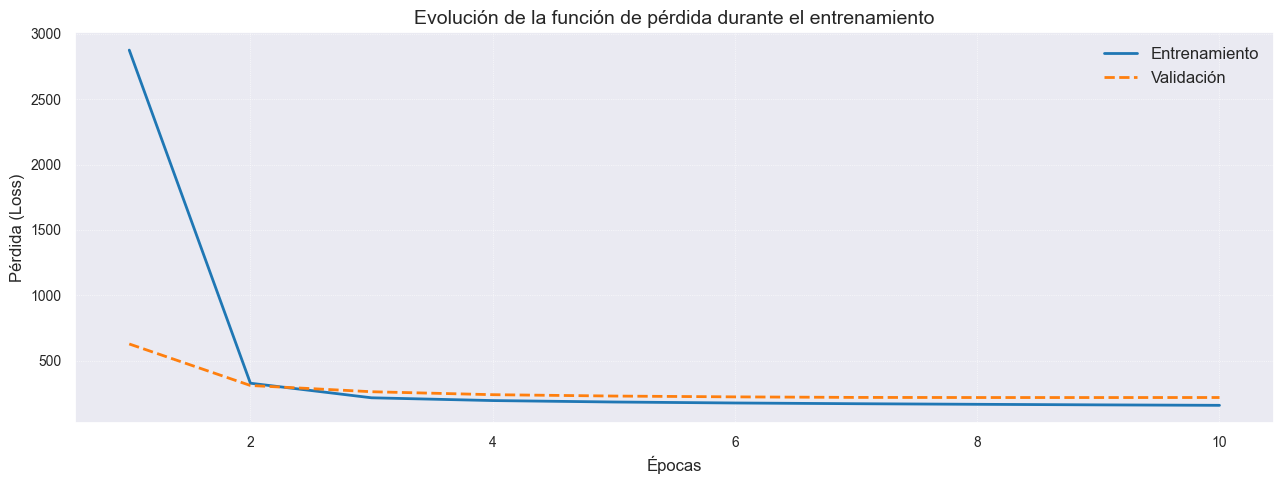

In [203]:
def plot_loss(fit_history):
    plt.figure(figsize=(13, 5))
    
    epochs = range(1, len(fit_history.history['loss']) + 1)

    # Líneas claras con estilos diferenciables
    plt.plot(epochs, fit_history.history['loss'], label='Entrenamiento', color='#1f77b4', linewidth=2)
    plt.plot(epochs, fit_history.history['val_loss'], label='Validación', color='#ff7f0e', linewidth=2, linestyle='--')
    
    # Etiquetas descriptivas y legibles
    plt.xlabel('Épocas', fontsize=12)
    plt.ylabel('Pérdida (Loss)', fontsize=12)
    plt.title('Evolución de la función de pérdida durante el entrenamiento', fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    # Mejora de la leyenda
    plt.legend(frameon=False, fontsize=12)
    
    # Elimina líneas innecesarias
    plt.grid(True, linestyle=':', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

plot_loss(history)

#### **Resultado.**

In [204]:
# predicción
y_hat_train = model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
evaluate(y_true.clip(upper=125), y_hat_test)

#y_hat_test = model.predict(test_array)
#evaluate(y_true.clip(upper=125), y_hat_test)

4591/4591 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step
train set RMSE: 12.9574, R²: 0.9033
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
test set RMSE: 13.7465, R²: 0.8933


In [205]:
#Experimentos 1: mismo preprocesamiento, alpha 0.1, escaler por condición, 

# Kmeans condición de operación
#train set RMSE: 12.8149, R²: 0.9054
#test set RMSE: 81.6167, R²: -2.7608

#   Condición de operación fija
#train set RMSE: 12.9574, R²: 0.9033
#test set RMSE: 13.7465, R²: 0.8933

In [206]:
#Experimentos 2: mismo prepocesamiento, alpha 0.1, pero con escaler distinto

# escalado por condición
#train set RMSE: 12.9625, R²: 0.9032
# #test set RMSE: 13.6377, R²: 0.8950

# escalado global
#train set RMSE: 19.6701, R²: 0.7771
#test set RMSE: 20.5192, R²: 0.7623

In [207]:
#Experimentos previos: mismo prepocesamiento pero con smothing (alpha) distinto y despues del escalamiento.

# sin fltro
#train set RMSE: 14.8856, R²: 0.8723
#test set RMSE: 15.5443, R²: 0.8636

# alpha 0.1
#train set RMSE: 12.9574, R²: 0.9033
#test set RMSE: 13.7465, R²: 0.8933

#alpha = 0.3
#train set RMSE: 14.5535, R²: 0.8780
#test set RMSE: 14.9006, R²: 0.8747

#alpha = 0.8
#train set RMSE: 15.2482, R²: 0.8661
#test set RMSE: 15.6763, R²: 0.8613

#### **Visualizaciones.**

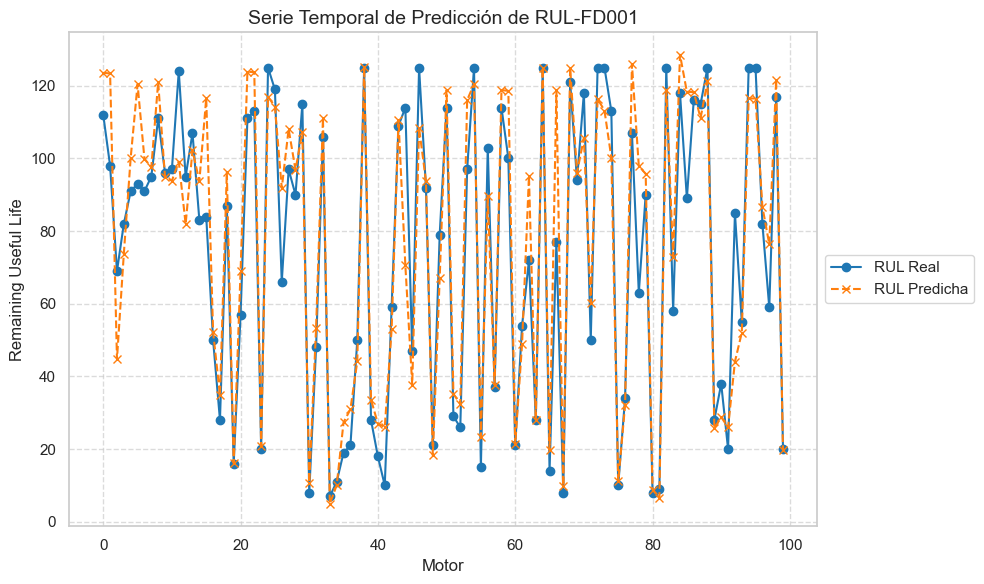

In [208]:
plot_rul_predictions(y_true.clip(upper=125)[:100], y_hat_test[:100], 'FD001')

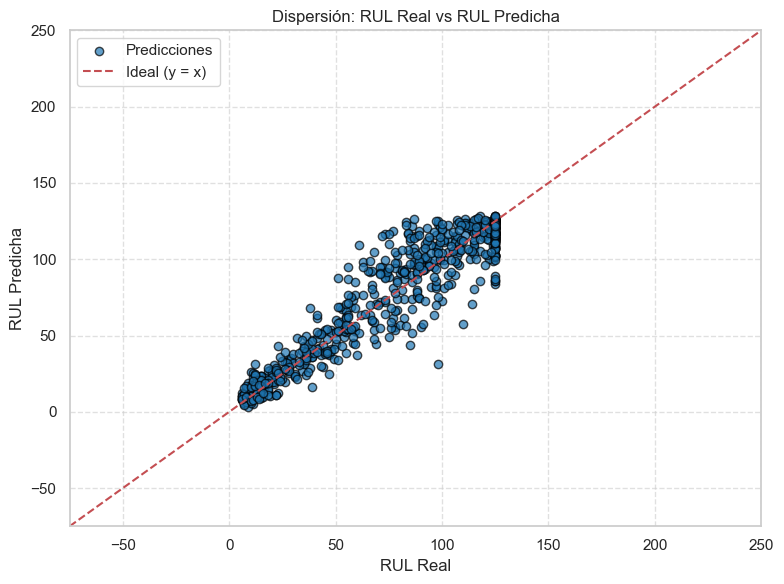

In [209]:
fig = plot_rul_comparison(y_true, y_hat_test, fixed_limits=True)

### **OPTIMIZACIÓN DE HIPERPARÁMETROS.**

Propósito general del código:

Este código tiene como objetivo explorar diferentes combinaciones de parámetros para encontrar la configuración óptima para un modelo LSTM entrenado con datos secuenciales. Es una forma de optimización de hiperparámetros usando una búsqueda aleatoria. La búsqueda aleatoria puede ser muy útil cuando no sabes exactamente qué valores de los parámetros producirán el mejor rendimiento.

Este proceso es bastante útil en el contexto de modelos de series temporales como el caso del análisis de la Remaining Useful Life (RUL) de motores o cualquier otro tipo de serie temporal que se pueda modelar con redes neuronales.

#### **DATOS.**

In [63]:
index_names = ['unit_nr', 'time_cycles']
setting_names = ['altitude', 'mach', 'temperature']
sensor_names = ["t2", "t24", "t30", "t50", "p2", "p15", "p30","nf", "nc", "epr", "ps30", "phi", "nrf", "nrc", "bpr", "farb",
            "htbleed", "nf_dmd", "pcnfr_dmd", "w31", "w32"]

In [62]:

def build_network_lstm(shape_input, layers_nodes, rate_dropout, func_activation, file_weights):
    set_seed(seed)
    network = Sequential()
    network.add(InputLayer(shape=shape_input))
    network.add(Masking(mask_value=-99.))
    if len(layers_nodes) <= 1:
        network.add(LSTM(layers_nodes[0], activation=func_activation,seed=seed))
        network.add(Dropout(rate_dropout))
    else:
        network.add(LSTM(layers_nodes[0], activation=func_activation,seed=seed, return_sequences=False))
        network.add(Dropout(rate_dropout))
        network.add(LSTM(layers_nodes[1], activation=func_activation))
        network.add(Dropout(rate_dropout))
    
    network.add(Dense(1))
    
    network.compile(loss='mean_squared_error', optimizer='adam')
    network.save_weights(file_weights)#por reproducibilidad
    return network

In [68]:
def preporcessing(train, test, drop_sensors, remaining_sensors, alpha):

    train = add_remaining_useful_life(train)
    train['RUL']=train['RUL'].clip(upper=125)
    train[['htbleed', 'nf_dmd']] = train[['htbleed', 'nf_dmd']].astype(float)
    test[['htbleed', 'nf_dmd']] = test[['htbleed', 'nf_dmd']].astype(float)
    X_train_interim = add_operating_condition(train.drop(drop_sensors, axis=1))
    X_test_interim = add_operating_condition(test.drop(drop_sensors, axis=1))

    X_train_interim, X_test_interim = scaling_by_condition(X_train_interim, X_test_interim, remaining_sensors)

    X_train_interim = time_series_smoothing(X_train_interim,["unit_nr"], remaining_sensors, alpha)
    X_test_interim = time_series_smoothing(X_test_interim,["unit_nr"], remaining_sensors,alpha)

    return X_train_interim, X_test_interim

In [80]:
# Eliminar sensores con baja correlación con RUL para selección de características
drop_sensors=low_corr_sensors[low_corr_sensors['Mutual_Information'] < 0.1].index.tolist()
remaining_sensors = [col for col in sensor_cols if col not in drop_sensors]

In [81]:
#Sé que los alfa más bajos funcionan mejor, por lo que podemos descartar algunos altos para reducir el espacio de búsqueda.
alpha_list = [0.01, 0.05] + list(np.arange(10,60+1,10)/100)

sequence_list = list(np.arange(10,40+1,5))
epoch_list = list(np.arange(5,20+1,5))
nodes_list = [[32], [64], [128], [256], [32, 64], [64, 128], [128, 256]]

# más bajo dropout= 0,1, porque sé que un dropout cero producirá mejores resultados de entrenamiento pero peor generalización
dropouts = list(np.arange(1,5)/10)  

activation_functions = ['tanh', 'sigmoid']
batch_size_list = [32, 64, 128,264]
sensor_list = [sensor_cols, remaining_sensors]

tuning_options = np.prod([len(alpha_list),
                          len(sequence_list),
                          len(epoch_list),
                          len(nodes_list),
                          len(dropouts),
                          len(activation_functions),
                          len(batch_size_list),
                          len(sensor_list)])
tuning_options

## la tasa de aprendizaje no se ha optimizado, debido a que adam es un optimizador adaptativo, y la tasa de aprendizaje se ajusta automáticamente.
## eso me da la opcion de reducir el espacio de busqueda

100352

In [82]:
drop_sensors

['p15', 'epr', 'p2', 't2', 'farb', 'nf_dmd', 'pcnfr_dmd']

100352 combinaciones posibles no termiariamos nunca si que se realizará una búsqueda aleatoria, que es una forma de busqueda de hiperparámetros.

#### **ITERACCIONES.**

In [254]:
#CPU times: total: 17h 25min 36s
#Wall time: 9h 3min 39s tiempo de ejecución con 10 interacciones
ITERATIONS=10 

In [255]:
%%time
results = pd.DataFrame(columns=['MSE', 'std_MSE', 'alpha',
                                'epochs', 'nodes', 'dropout', 
                                'activation', 'batch_size', 
                                'sequence_length', 'sensor_length'])  # Saldrá un warning ya que la primera fila no tiene información.

weights_file = 'lstm_hyper_parameter.weights.h5'

for i in range(ITERATIONS):
    if ITERATIONS < 10:
        print('iteration ', i+1)
    elif ((i+1) % 10 == 0):
        print('iteration ', i+1)
    
    mse = []
    
    # parámetros iniciales randómicos
    alpha = random.sample(alpha_list, 1)[0]
    sequence_length = random.sample(sequence_list, 1)[0]
    epochs = random.sample(epoch_list, 1)[0]
    nodes_per_layer = random.sample(nodes_list, 1)[0]
    dropout = random.sample(dropouts, 1)[0]
    activation = random.sample(activation_functions, 1)[0]
    batch_size = random.sample(batch_size_list, 1)[0]
    remaining_sensors = random.sample(sensor_list, 1)[0]
    drop_sensors = [element for element in sensor_names if element not in remaining_sensors]
    
    # crear el modelo
    input_shape = (sequence_length, len(remaining_sensors))
    model = build_network_lstm(input_shape, nodes_per_layer, dropout, activation, weights_file)

    # crear train-val split
    X_train_opt,X_test_opt = preporcessing(df_train, df_test, drop_sensors, remaining_sensors, alpha)
    gss = GroupShuffleSplit(n_splits=3, train_size=0.80, random_state=42)
    for train_unit, val_unit in gss.split(X_train_opt['unit_nr'].unique(), groups=X_train_opt['unit_nr'].unique()):
        train_unit = X_train_opt['unit_nr'].unique()[train_unit]  # gss retorna indices y empieza en 1
        train_split_array = create_sequences(X_train_opt, sequence_length, remaining_sensors, train_unit)
        train_split_label = create_labels(X_train_opt, sequence_length, ['RUL'], train_unit)
        
        val_unit = X_train_opt['unit_nr'].unique()[val_unit]
        val_split_array = create_sequences(X_train_opt, sequence_length, remaining_sensors, val_unit)
        val_split_label = create_labels(X_train_opt, sequence_length, ['RUL'], val_unit)
        
        # entrenar y evaluar
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.load_weights(weights_file)  # resetear el optimizador por temas de reproduciilidad
        
        history = model.fit(train_split_array, train_split_label,
                            validation_data=(val_split_array, val_split_label),
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=0)
        mse.append(history.history['val_loss'][-1])
    
    # unir results
    d = {'MSE':np.mean(mse), 'std_MSE':np.std(mse), 'alpha':alpha, 
         'epochs':epochs, 'nodes':str(nodes_per_layer), 'dropout':dropout, 
         'activation':activation, 'batch_size':batch_size, 'sequence_length':sequence_length,
         'sensor_length':len(remaining_sensors)}
    print(f'Resultados de la iteracción: {i} , {d}')
    results = pd.concat([results, pd.DataFrame([d])], ignore_index=True)  


Resultados de la iteracción: 0 , {'MSE': 299.5440165201823, 'std_MSE': 21.924053176205287, 'alpha': 0.3, 'epochs': 10, 'nodes': '[64]', 'dropout': 0.1, 'activation': 'tanh', 'batch_size': 264, 'sequence_length': 15, 'sensor_length': 21}


<timed exec>:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Resultados de la iteracción: 1 , {'MSE': 299.5440165201823, 'std_MSE': 21.924053176205287, 'alpha': 0.3, 'epochs': 10, 'nodes': '[64]', 'dropout': 0.1, 'activation': 'tanh', 'batch_size': 264, 'sequence_length': 15, 'sensor_length': 21}
Resultados de la iteracción: 2 , {'MSE': 299.5440165201823, 'std_MSE': 21.924053176205287, 'alpha': 0.3, 'epochs': 10, 'nodes': '[64]', 'dropout': 0.1, 'activation': 'tanh', 'batch_size': 264, 'sequence_length': 15, 'sensor_length': 21}
Resultados de la iteracción: 3 , {'MSE': 299.5440165201823, 'std_MSE': 21.924053176205287, 'alpha': 0.3, 'epochs': 10, 'nodes': '[64]', 'dropout': 0.1, 'activation': 'tanh', 'batch_size': 264, 'sequence_length': 15, 'sensor_length': 21}
Resultados de la iteracción: 4 , {'MSE': 299.5440165201823, 'std_MSE': 21.924053176205287, 'alpha': 0.3, 'epochs': 10, 'nodes': '[64]', 'dropout': 0.1, 'activation': 'tanh', 'batch_size': 264, 'sequence_length': 15, 'sensor_length': 21}
Resultados de la iteracción: 5 , {'MSE': 299.5440165

In [256]:
results.sort_values('MSE')

,MSE,std_MSE,alpha,epochs,nodes,dropout,activation,batch_size,sequence_length,sensor_length
0,299.544017,21.924053,0.3,10,[64],0.1,tanh,264,15,21
1,299.544017,21.924053,0.3,10,[64],0.1,tanh,264,15,21
2,299.544017,21.924053,0.3,10,[64],0.1,tanh,264,15,21
3,299.544017,21.924053,0.3,10,[64],0.1,tanh,264,15,21
4,299.544017,21.924053,0.3,10,[64],0.1,tanh,264,15,21
5,299.544017,21.924053,0.3,10,[64],0.1,tanh,264,15,21
6,299.544017,21.924053,0.3,10,[64],0.1,tanh,264,15,21
7,299.544017,21.924053,0.3,10,[64],0.1,tanh,264,15,21
8,299.544017,21.924053,0.3,10,[64],0.1,tanh,264,15,21
9,299.544017,21.924053,0.3,10,[64],0.1,tanh,264,15,21


In [257]:
results.to_csv('results.csv', index=False)

### **MODELO FINAL OPTIMIZADO.**

En una prueba aleatoria el mínimo valor que obtuve fue mse 163.35.

In [58]:
drop_sensors=[] # vimos que el modelo se comportaba mejor con mas características del dataset de acuerdo a la optimizacion

In [59]:
remaining_sensors= [col for col in sensor_cols if col not in drop_sensors]

In [ ]:
#40min aprox tiempo de ejecución
#Hyperparámetros obtenidos
alpha = 0.1
sequence_length = 30
nodes_per_layer = [256] # 
activation = 'sigmoid'
weights_file = 'full_model.weights.h5'
epochs = 15  
batch_size = 128
dropout = 0.1

# prep data
X_train_opt, X_test_opt = preporcessing(df_train, df_test, drop_sensors, remaining_sensors, alpha)

train_split_array, train_split_label, val_split_array, val_split_label, train_array, label_array, test_array = prepare_sequential_data(
        X_train_opt,
        X_test_opt,
        sequence_length,
        remaining_sensors,
        ['RUL'],
        -99.,
        create_sequences,
        create_labels,
        create_test_sequences,
        n_slpits=1
        )

input_shape = (sequence_length, len(remaining_sensors))
final_model = build_network_lstm(input_shape, nodes_per_layer, dropout, activation, weights_file)

final_model.compile(loss='mean_squared_error', optimizer='adam')#por reproducibilidad
final_model.load_weights(weights_file)#por reproducibilidad

final_model.fit(train_array, label_array,validation_data=(val_split_array, val_split_label),
                epochs=epochs,
                batch_size=batch_size)


Epoch 1/15
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 168s 149ms/step - loss: 4083.7332 - val_loss: 527.6446
Epoch 2/15
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 172s 121ms/step - loss: 334.0045 - val_loss: 208.6092
Epoch 3/15
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 151s 138ms/step - loss: 193.6959 - val_loss: 169.9345
Epoch 4/15
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 133s 122ms/step - loss: 174.4880 - val_loss: 161.1390
Epoch 5/15
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 140s 128ms/step - loss: 168.2711 - val_loss: 158.9851
Epoch 6/15
 613/1093 ━━━━━━━━━━━━━━━━━━━━ 56s 118ms/step - loss: 164.4869

1093/1093 ━━━━━━━━━━━━━━━━━━━━ 136s 124ms/step - loss: 163.4738 - val_loss: 154.9547
Epoch 7/15
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 169s 149ms/step - loss: 160.0896 - val_loss: 155.8368
Epoch 8/15
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 137s 125ms/step - loss: 158.4971 - val_loss: 161.3402
Epoch 9/15
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 178s 162ms/step - loss: 156.7526 - val_loss: 151.5094
Epoch 10/15
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 170s 133ms/step - loss: 154.6413 - val_loss: 148.6976
Epoch 11/15
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 243s 170ms/step - loss: 153.7462 - val_loss: 144.2353
Epoch 12/15
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 158s 130ms/step - loss: 152.0247 - val_loss: 145.3077
Epoch 13/15
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 169s 154ms/step - loss: 151.0568 - val_loss: 142.1361
Epoch 14/15
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 176s 131ms/step - loss: 148.5710 - val_loss: 141.3211
Epoch 15/15
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 171s 156ms/step - loss: 147.8076 - val_loss: 141.3927


In [213]:
# predict and evaluate
y_hat_train = final_model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = final_model.predict(test_array)
evaluate(y_true.clip(upper=125), y_hat_test)

4369/4369 ━━━━━━━━━━━━━━━━━━━━ 105s 24ms/step
train set RMSE: 12.0275, R²: 0.9173
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
test set RMSE: 13.1740, R²: 0.9020


#### **Visualizaciones.**

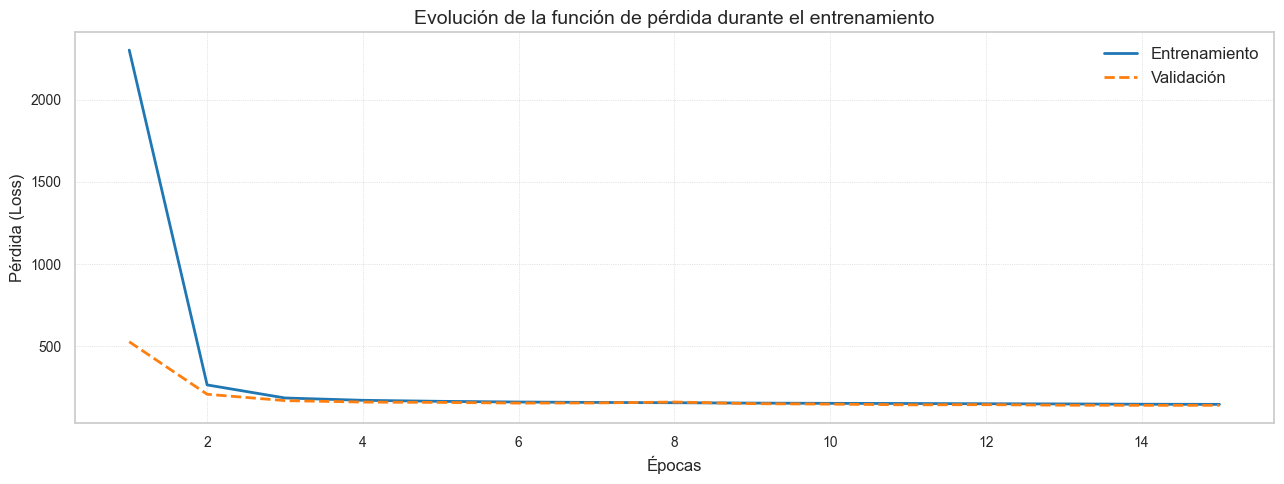

In [214]:
def plot_loss(fit_history):
    plt.figure(figsize=(13, 5))
    
    epochs = range(1, len(fit_history.history['loss']) + 1)

    # Líneas claras con estilos diferenciables
    plt.plot(epochs, fit_history.history['loss'], label='Entrenamiento', color='#1f77b4', linewidth=2)
    plt.plot(epochs, fit_history.history['val_loss'], label='Validación', color='#ff7f0e', linewidth=2, linestyle='--')
    
    # Etiquetas descriptivas y legibles
    plt.xlabel('Épocas', fontsize=12)
    plt.ylabel('Pérdida (Loss)', fontsize=12)
    plt.title('Evolución de la función de pérdida durante el entrenamiento', fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    # Mejora de la leyenda
    plt.legend(frameon=False, fontsize=12)
    
    # Elimina líneas innecesarias
    plt.grid(True, linestyle=':', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

plot_loss(final_model.history)

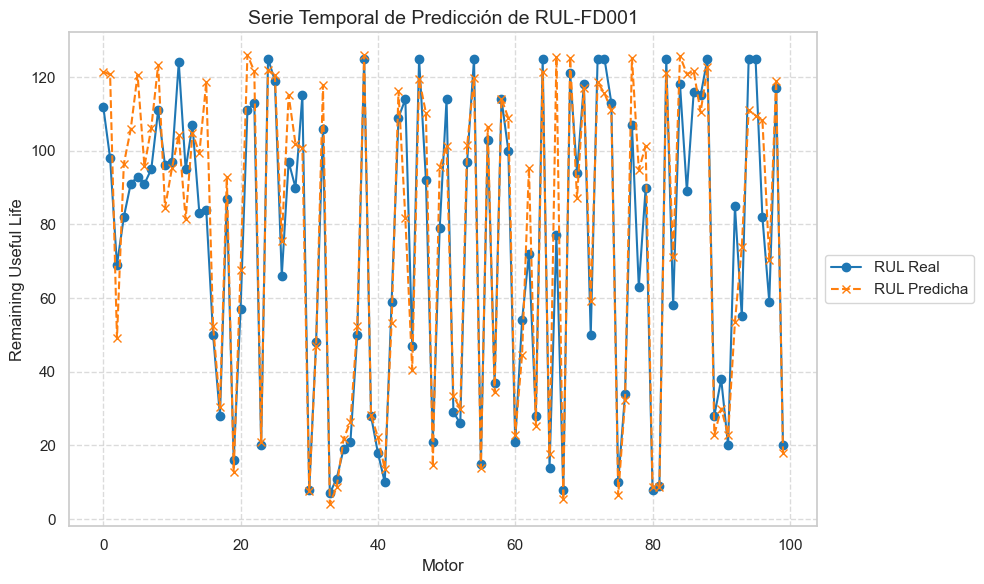

In [215]:
# plot predictions
plot_rul_predictions(y_true.clip(upper=125)[:100], y_hat_test[:100],'FD001')  # Serie temporal

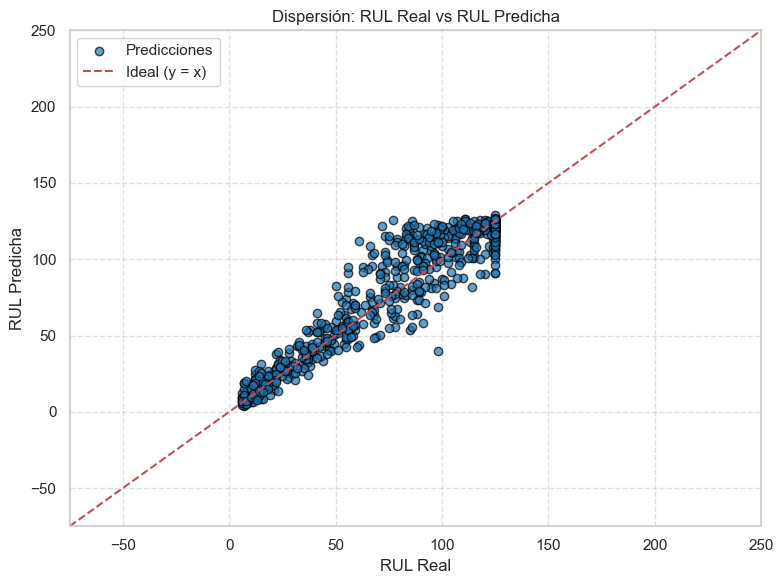

In [216]:
fig = plot_rul_comparison(y_true, y_hat_test, fixed_limits=True)

In [217]:
#final_model.save('final_lstm_model_best.keras')
#final_model.save_weights('final_lstm_model_best.weights.h5')

El mejor modelo tiene metricas de test set RMSE: 13.17, R²: 0.9020, mejor de lo que esperaba.

### **REFERENCIAS.**

[1] J. Brownlee, “LSTM for Predictive Maintenance of Turbofan Engines,” Towards Data Science, 2021. [Online]. Available: https://towardsdatascience.com/lstm-for-predictive-maintenance-of-turbofan-engines-f8c7791353f3 [Accessed: 19-Ago-2024].

[2] A. Saxena, J. Celaya, B. Saha, and K. Goebel, “Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation,” NASA Ames Research Center, Moffett Field, CA, USA, Tech. Rep. NASA/TM-2007-214430, 2007. [Online]. Available: https://ntrs.nasa.gov/citations/20070034949

[3] M. Koot, "Lagged MLP for Predictive Maintenance of Turbofan Engines," Towards Data Science, 2021. [Online]. Available: https://towardsdatascience.com/lagged-mlp-for-predictive-maintenance-of-turbofan-engines-c79f02a15329. [Accessed: 19-Ago-2024].

[4] Microsoft Azure, “LSTMs for Predictive Maintenance,” GitHub, 2019. [Online]. Available: https://github.com/Azure/lstms_for_predictive_maintenance. [Accessed: 22-Nov-2024].